# Data Parsing, Cleansing and Integration

Libraries used: please include the main libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy

## Introduction
Brief information of this assessment, e.g., what problems were this assessment tackling, what problems were discovered in the data while you were parsing or cleansing it, and the approaches you chose to handle them, etc.

<span style="color: red"> Note that this is a sample notebook only. You will need to fill in the proper markdown and code blocks. You might also want to make necessary changes to the structure to meet your own needs. Note also that any generic comments written in this notebook are to be removed and replace with your own words.</span>

## Importing libraries 

In [72]:
# Code to import libraries as you need in this assessment, e.g.,
import pandas as pd
import re
import numpy as np
import xml.etree.ElementTree as et
import seaborn as sns
import matplotlib as plt

## Task 1. Parsing Data

### 1.1. Examining and loading data


In [73]:
# Code to inspect the provided data file
# Couple of notes for all code block in this notebook
## please provide proper comment on your code
## Please re-start and run all cells to make sure codes are runable and include your output in the submission
xtree = et.parse("dataset1.xml")
xroot = xtree.getroot()

### 1.2 Parsing data into the required format

In [74]:
# # Code to parse data
job_list = []

for source in xroot:
    sourceName = source.attrib.get("SourceName")
    
    for node in source.findall("JobAd"):
        job_data = {
        "Id" : node.find("Id").text
        ,"Title" : node.find("Title").text if node.find("Title") is not None else "non-specified"
        ,"Location" : node.find("Location").text if node.find("Location") is not None else "non-specified"
        ,"Company" : node.find("Company").text if node.find("Company") is not None else "non-specified"
        ,"ContractType" : node.find("ContractType").text if node.find("ContractType") is not None else "-"
        ,"ContractTime" : node.find("ContractTime").text if node.find("ContractTime") is not None else "-"
        ,"Category" : node.find("Category").text
        ,"Salary" : node.find("Salary").text if node.find("Salary") is not None else np.NaN # needs to be not null
        ,"OpenDate" : node.find("Date").attrib.get("Open")
        ,"CloseDate" : node.find("Date").attrib.get("Close")
        ,"SourceName" : sourceName if sourceName is not None else "-"
        }
        
    job_list.append(job_data)

df = pd.DataFrame(job_list)
original = df

df.head()


,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,70761086,Antipodean Teachers Urgently,London,Sugarman Medical,-,permanent,Teaching Jobs,36000,20130713T000000,20130812T000000,cv-library.co.uk
1,71095030,Deputy Hospital Manager Bedford,Bedford,Brookdale Care,full_time,,Healthcare & Nursing Jobs,60000,20120721T000000,20120919T000000,staffnurse.com
2,72221399,Licensee Auditor,Berkshire,Hays,full_time,permanent,Accounting & Finance Jobs,42500,20120118T150000,20120318T150000,GAAPweb
3,51285926,Home Manager Sheffield ****K,Sheffield,-,-,-,Healthcare & Nursing Jobs,37500,20120427T000000,20120511T000000,careworx.co.uk
4,69173865,Air Conditioning & Refrigeration (North London),UK,Riverside Technical Solutions Limited,-,permanent,Engineering Jobs,32000,20130508T120000,20130806T120000,totaljobs.com


......

## Task 2. Auditing and cleansing the loaded data

In [75]:
# Code to audit data
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,70761086,Antipodean Teachers Urgently,London,Sugarman Medical,-,permanent,Teaching Jobs,36000,20130713T000000,20130812T000000,cv-library.co.uk
1,71095030,Deputy Hospital Manager Bedford,Bedford,Brookdale Care,full_time,,Healthcare & Nursing Jobs,60000,20120721T000000,20120919T000000,staffnurse.com
2,72221399,Licensee Auditor,Berkshire,Hays,full_time,permanent,Accounting & Finance Jobs,42500,20120118T150000,20120318T150000,GAAPweb
3,51285926,Home Manager Sheffield ****K,Sheffield,-,-,-,Healthcare & Nursing Jobs,37500,20120427T000000,20120511T000000,careworx.co.uk
4,69173865,Air Conditioning & Refrigeration (North London),UK,Riverside Technical Solutions Limited,-,permanent,Engineering Jobs,32000,20130508T120000,20130806T120000,totaljobs.com


......

In [76]:
df.dtypes

Id              object
Title           object
Location        object
Company         object
ContractType    object
ContractTime    object
Category        object
Salary          object
OpenDate        object
CloseDate       object
SourceName      object
dtype: object

# Error Checking
- Spellings
- Value Errors
- Null values
- Duplicated Names (The City meaning London), Category, Company having similar names

*More error checks are done at the end of the notebook before creating a .csv file*

In [77]:
replace_dict = {"-":np.nan, "40000/year":40000}
company_replace_dict = {" ":"non-specified", "-":"non-specified", "":"non-specified","N/A":"non-specified","permanent":"full_time"}
city_dict = {"The City":"London"}
all_errors = []  # List to store temporary error DataFrames

for col in df.columns:
    if col == 'Id':  # Skip the 'Id' column
        continue
    
    error_rows = []
    error_fixing = {}
    error_types = {}
    
    # Stripping Extra Spaces
    if df[col].dtype == 'object':
        space_mask = (df[col] != df[col].str.strip()) | (df[col] != df[col].str.replace(r'\s+', ' ', regex=True))
        space_indices = df[space_mask].index.tolist()
        error_rows.extend(space_indices)
        for idx in space_indices:
            error_fixing[idx] = "Extra spaces found"
            error_types[idx] = "Value Error"
    
    # Replacing The City with London
    for key, value in city_dict.items():
        mask = df[col] == key
        indices = df[mask].index.tolist()
        error_rows.extend(indices)
        for idx in indices:
            error_fixing[idx] = f"replaced '{key}' with {value}"
            error_types[idx] = "The City = London"
    
    # Strings that need to be replaced before changing dtypes        
    for key, value in replace_dict.items():
        mask = df[col] == key
        indices = df[mask].index.tolist()
        error_rows.extend(indices)
        for idx in indices:
            error_fixing[idx] = f"replaced '{key}' with {value}"
            error_types[idx] = "Incorrect Value"
            
    # Strings that need to be replaced before changing dtypes or to keep the schema intact.       
    for key, value in company_replace_dict.items():
        mask = df[col] == key
        indices = df[mask].index.tolist()
        error_rows.extend(indices)
        for idx in indices:
            error_fixing[idx] = f"replaced '{key}' with {value}"
            error_types[idx] = "Incorrect Value"
    
    if error_rows:
        temp_df = df.loc[error_rows].copy()
        temp_df['indexOfdf'] = temp_df.index
        temp_df['ColumnName'] = col
        temp_df['Original'] = temp_df[col]
        temp_df['Modified'] = temp_df[col].replace(replace_dict).replace(company_replace_dict)
        temp_df['ErrorType'] = temp_df.index.map(error_types) 
        temp_df['Fixing'] = temp_df.index.map(error_fixing)  
        all_errors.append(temp_df[['indexOfdf', 'Id', 'ColumnName', 'Original', 'Modified', 'ErrorType', 'Fixing']])

if all_errors:
    # Concatenate all error DataFrames
    error_df = pd.concat(all_errors, ignore_index=True)
    
    # Save to CSV
    error_df.to_csv('error_report.csv', index=False)
else:
    print("No errors found.")


df.Salary.replace(replace_dict, inplace=True)
df.Company.replace(company_replace_dict, inplace=True)
df.ContractType.replace(company_replace_dict, inplace=True)
df.ContractTime.replace(company_replace_dict, inplace=True)
df.Location.replace(city_dict, inplace=True)

In [78]:
print(df.Category.value_counts())

Category
Accounting & Finance Jobs           25
Engineering Jobs                    19
Healthcare & Nursing Jobs           18
IT Jobs                             14
Teaching Jobs                       10
PR, Advertising & Marketing Jobs     9
Sales Jobs                           7
Hospitality & Catering Jobs          5
Name: count, dtype: int64


In [79]:
#pd.crosstab(df.Title, df.Id)

dfcols = df.columns
for x in dfcols:
    print(f"\nUnique values in column {x}:\n{df[x].unique()}")

df.head()



Unique values in column Id:
['70761086' '71095030' '72221399' '51285926' '69173865' '66434366'
 '69690848' '68350722' '66762091' '70442614' '72126746' '67378957'
 '72126757' '69680014' '71595338' '68718724' '71335297' '68293653'
 '69794277' '62121276' '72126768' '68805766' '71569250' '68497859'
 '67996704' '70408351' '71742394' '55408514' '66685177' '71230677'
 '67389667' '69635476' '67774572' '72126790' '72226595' '66346584'
 '71858079' '63045680' '67155175' '62014003' '72385733' '69024674'
 '70586684' '69948651' '69117118' '71597001' '68808563' '69569026'
 '72300706' '69116955' '56365939' '72428502' '70344010' '71888713'
 '67389428' '67762170' '69258705' '71391790' '71472657' '68804926'
 '72395147' '69538814' '68561569' '69537662' '71098756' '69668605'
 '68256082' '72393621' '66918090' '72423805' '69856102' '71501371'
 '66795841' '68445078' '67385423' '69962425' '68291605' '70623400'
 '69005978' '66701506' '68802221' '71072614' '72610078' '60358679'
 '58099189' '68227540' '66645648'

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,70761086,Antipodean Teachers Urgently,London,Sugarman Medical,non-specified,full_time,Teaching Jobs,36000,20130713T000000,20130812T000000,cv-library.co.uk
1,71095030,Deputy Hospital Manager Bedford,Bedford,Brookdale Care,full_time,non-specified,Healthcare & Nursing Jobs,60000,20120721T000000,20120919T000000,staffnurse.com
2,72221399,Licensee Auditor,Berkshire,Hays,full_time,full_time,Accounting & Finance Jobs,42500,20120118T150000,20120318T150000,GAAPweb
3,51285926,Home Manager Sheffield ****K,Sheffield,non-specified,non-specified,non-specified,Healthcare & Nursing Jobs,37500,20120427T000000,20120511T000000,careworx.co.uk
4,69173865,Air Conditioning & Refrigeration (North London),UK,Riverside Technical Solutions Limited,non-specified,full_time,Engineering Jobs,32000,20130508T120000,20130806T120000,totaljobs.com


In [80]:
df.Location.value_counts()

Location
London                      27
UK                          11
Central London               3
South East London            3
Cheltenham                   2
Surrey                       2
Lancashire                   2
Scotland                     2
Kent                         2
Reading                      2
Glasgow                      2
Derby                        2
Berkshire                    2
Milton Keynes                2
Leicestershire               1
Newbury                      1
North East England           1
East Midlands                1
Yorkshire and Humberside     1
Cambridge                    1
Crewe                        1
Luton                        1
Northamptonshire             1
Maidenhead                   1
Bath                         1
Guildford                    1
Belfast                      1
Jersey                       1
Dunfermline                  1
West Sussex                  1
Worcestershire               1
Nottingham                   1

In [81]:
pd.set_option('display.max_rows', 500)
df.SourceName.value_counts()


SourceName
cv-library.co.uk                  1
contractjobs.com                  1
scotsman.com                      1
Multilingualvacancies             1
jobs.telegraph.co.uk              1
professionalpensionsjobs.com      1
nijobs.com                        1
wikijob.co.uk                     1
securityclearedjobs.com           1
jobstoday.co.uk                   1
ifaonlinejobs.co.uk               1
gorkanajobs.co.uk                 1
jobsinscotland.com                1
ncejobs.co.uk                     1
simplysalesjobs.co.uk             1
nijobfinder.co.uk                 1
london4jobs.co.uk                 1
jobs.electronicsweekly.com        1
jobg8.com                         1
jobsinrisk.com                    1
careers4a.com                     1
rengineeringjobs.com              1
justengineers.net                 1
insurancejobs.co.uk               1
careerbuilder.com                 1
mediaweekjobs.co.uk               1
JobSearch                         1
jobs.newstatesman

In [82]:
pd.reset_option('display.max_rows')


# Dates
- Converting to DateTime format

In [83]:
df.OpenDate = pd.to_datetime(df.OpenDate)
formatted_dates = df.OpenDate.dt.strftime('%Y-%m-%d %H:%M:%S')
df.OpenDate = pd.to_datetime(formatted_dates)

df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,70761086,Antipodean Teachers Urgently,London,Sugarman Medical,non-specified,full_time,Teaching Jobs,36000,2013-07-13 00:00:00,20130812T000000,cv-library.co.uk
1,71095030,Deputy Hospital Manager Bedford,Bedford,Brookdale Care,full_time,non-specified,Healthcare & Nursing Jobs,60000,2012-07-21 00:00:00,20120919T000000,staffnurse.com
2,72221399,Licensee Auditor,Berkshire,Hays,full_time,full_time,Accounting & Finance Jobs,42500,2012-01-18 15:00:00,20120318T150000,GAAPweb
3,51285926,Home Manager Sheffield ****K,Sheffield,non-specified,non-specified,non-specified,Healthcare & Nursing Jobs,37500,2012-04-27 00:00:00,20120511T000000,careworx.co.uk
4,69173865,Air Conditioning & Refrigeration (North London),UK,Riverside Technical Solutions Limited,non-specified,full_time,Engineering Jobs,32000,2013-05-08 12:00:00,20130806T120000,totaljobs.com


In [84]:
df.CloseDate = pd.to_datetime(df.CloseDate)
formatted_dates = df.CloseDate.dt.strftime('%Y-%m-%d %H:%M:%S')
df.CloseDate = pd.to_datetime(df.CloseDate)
df.head()

,Id,Title,Location,Company,ContractType,ContractTime,Category,Salary,OpenDate,CloseDate,SourceName
0,70761086,Antipodean Teachers Urgently,London,Sugarman Medical,non-specified,full_time,Teaching Jobs,36000,2013-07-13 00:00:00,2013-08-12 00:00:00,cv-library.co.uk
1,71095030,Deputy Hospital Manager Bedford,Bedford,Brookdale Care,full_time,non-specified,Healthcare & Nursing Jobs,60000,2012-07-21 00:00:00,2012-09-19 00:00:00,staffnurse.com
2,72221399,Licensee Auditor,Berkshire,Hays,full_time,full_time,Accounting & Finance Jobs,42500,2012-01-18 15:00:00,2012-03-18 15:00:00,GAAPweb
3,51285926,Home Manager Sheffield ****K,Sheffield,non-specified,non-specified,non-specified,Healthcare & Nursing Jobs,37500,2012-04-27 00:00:00,2012-05-11 00:00:00,careworx.co.uk
4,69173865,Air Conditioning & Refrigeration (North London),UK,Riverside Technical Solutions Limited,non-specified,full_time,Engineering Jobs,32000,2013-05-08 12:00:00,2013-08-06 12:00:00,totaljobs.com


# DataTypes
- Giving each column the proper datatype

In [85]:
df.dtypes


Id                      object
Title                   object
Location                object
Company                 object
ContractType            object
ContractTime            object
Category                object
Salary                  object
OpenDate        datetime64[ns]
CloseDate       datetime64[ns]
SourceName              object
dtype: object

In [86]:
df.columns

Index(['Id', 'Title', 'Location', 'Company', 'ContractType', 'ContractTime',
       'Category', 'Salary', 'OpenDate', 'CloseDate', 'SourceName'],
      dtype='object')

In [87]:
df.Id = df.Id.astype('int32')
df.Title = df.Title.astype('string')
df.Location = df.Location.astype('string')
df.Company = df.Company.astype('string')
df.ContractType = df.ContractType.astype('string')
df.ContractTime = df.ContractTime.astype('string')
df.Category = df.Category.astype('string')
df.Salary = df.Salary.astype('float')
df.SourceName = df.SourceName.astype('string')

df.dtypes

Id                       int32
Title           string[python]
Location        string[python]
Company         string[python]
ContractType    string[python]
ContractTime    string[python]
Category        string[python]
Salary                 float64
OpenDate        datetime64[ns]
CloseDate       datetime64[ns]
SourceName      string[python]
dtype: object

# Duplicates & Outliers
- Analyse duplicates and see if there are unnecessary duplicates
- Analyse unique values to ensure there are no value errors

Upper Bound IQR:
          Id                                              Title  \
7   68350722                               Enterprise Architect   
29  71230677  Data Analyst/Modeller  GLASGOW  CONTRACT  BANKING   

         Location        Company   ContractType ContractTime  \
7   Milton Keynes  non-specified  non-specified    full_time   
29        Glasgow  non-specified  non-specified     contract   

                     Category   Salary   OpenDate  CloseDate        SourceName  
7                     IT Jobs  90000.0 2012-03-10 2012-05-09  technojobs.co.uk  
29  Accounting & Finance Jobs  87000.0 2012-05-20 2012-06-19        hays.co.uk  

Lower Bound IQR:
Empty DataFrame
Columns: [Id, Title, Location, Company, ContractType, ContractTime, Category, Salary, OpenDate, CloseDate, SourceName]
Index: []

Column Id has 0 duplicates
Column Title has 0 duplicates
Column Location has 50 duplicates
Column Company has 20 duplicates
Column ContractType has 104 duplicates
Column ContractTim

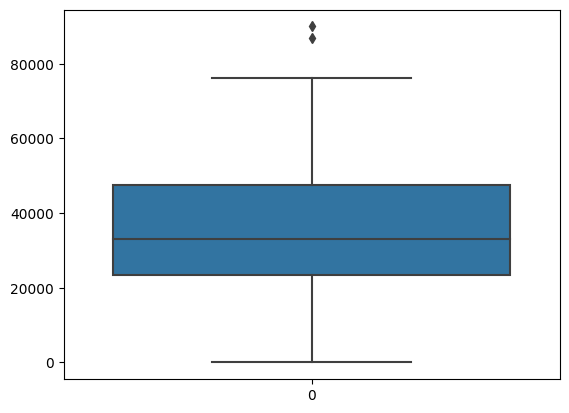

In [88]:
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
sns.boxplot(df.Salary)
print(f'Upper Bound IQR:\n{df[df.Salary > upper_bound]}\n')
print(f'Lower Bound IQR:\n{df[df.Salary < lower_bound]}\n')


for x in dfcols:
    print(f"Column {x} has {df[x].duplicated().sum()} duplicates")
print()
for x in dfcols:
    print(f"Column {x} has {len(df[x].unique())} unique values")
print()

for x in df['Id'].values:
    if len(str(x)) >8:
        print(x)
    else:
        print(None)
        break


# Finalizing & Creating Errorlist

In [89]:
def add_extra_row(index, id_val, column_name, original, modified, error_type, fixing):
    extra_row = pd.DataFrame({
        'indexOfdf': [index],
        'Id': [id_val],
        'ColumnName': [column_name],
        'Original': [original],
        'Modified': [modified],
        'ErrorType': [error_type],
        'Fixing': [fixing]
    })
    all_errors.append(extra_row)
add_extra_row('All', 'All', 'Id', 'object','int32', 'Wrong Datatype', 'object -> int32')
add_extra_row('All', 'All', 'Title', 'object','string', 'Wrong Datatype', 'object -> string')
add_extra_row('All', 'All', 'Location', 'object','string', 'Wrong Datatype', 'object -> string')
add_extra_row('All', 'All', 'Company', 'object','string', 'Wrong Datatype', 'object -> string')
add_extra_row('All', 'All', 'ContractType', 'object','string', 'Wrong Datatype', 'object -> string')
add_extra_row('All', 'All', 'ContractTime', 'object','string', 'Wrong Datatype', 'object -> string')
add_extra_row('All', 'All', 'Category', 'object','string', 'Wrong Datatype', 'object -> string')
add_extra_row('All', 'All', 'Salary', 'object','float', 'Wrong Datatype', 'object -> float')
add_extra_row('All', 'All', 'OpenDate', 'object','datetime', 'Wrong Datatype', 'object -> strftime %Y-%m-%d %H:%M:%S -> datetime')
add_extra_row('All', 'All', 'CloseDate', 'object','datetime', 'Wrong Datatype', 'object -> strftime %Y-%m-%d %H:%M:%S -> datetime')
add_extra_row('All', 'All', 'SourceName', 'object','string', 'Wrong Datatype', 'object -> string')

In [90]:
if 'Salary' in df.columns:
    Q1 = df['Salary'].quantile(0.25)
    Q3 = df['Salary'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df['Salary'] < lower_bound) | (df['Salary'] > upper_bound)
    outlier_indices = df[outlier_mask].index.tolist()
    for idx in outlier_indices:
        error_fixing[idx] = f"Value '{df['Salary'].loc[idx]}' is an outlier"
        error_types[idx] = "Incorrect Value"
    
    if outlier_indices:
        temp_df = df.loc[outlier_indices].copy()
        temp_df['indexOfdf'] = temp_df.index
        temp_df['ColumnName'] = 'Salary'
        temp_df['Original'] = temp_df['Salary']
        temp_df['Modified'] = 'None, should be removed, but was told in lecture not to drop these.'  
        temp_df['ErrorType'] = temp_df.index.map(error_types)
        temp_df['Fixing'] = temp_df.index.map(error_fixing) 
        
        all_errors.append(temp_df[['indexOfdf', 'Id', 'ColumnName', 'Original', 'Modified', 'ErrorType', 'Fixing']])

if all_errors:
    # Concatenate all error DataFrames
    error_df = pd.concat(all_errors, ignore_index=True)
    
    # Save to CSV
    error_df.to_csv('error_report.csv', index=False)
else:
    print("No errors found.")

# Creating Errorlist.csv

In [91]:
errordf = pd.read_csv('s3972733_errorlist.csv')
error_df.head()
display(error_df.head())


,indexOfdf,Id,ColumnName,Original,Modified,ErrorType,Fixing
0,1,71095030,Title,Deputy Hospital Manager Bedford,Deputy Hospital Manager Bedford,Value Error,Extra spaces found
1,5,66434366,Title,Analogue/Digital Engineer contract 6 months,Analogue/Digital Engineer contract 6 months,Value Error,Extra spaces found
2,6,69690848,Title,Assistant Consultant Mechanical/Electrical,Assistant Consultant Mechanical/Electrical,Value Error,Extra spaces found
3,10,72126746,Title,Exchange Administrator London **** **** day...,Exchange Administrator London **** **** day...,Value Error,Extra spaces found
4,12,72126757,Title,KITCHEN MANAGER GASTRO PUB AND RESTAURANT,KITCHEN MANAGER GASTRO PUB AND RESTAURANT,Value Error,Extra spaces found


## Saving data
Save the parsed and cleaned data as well as the error list, named as:
- \<student\_id\>_dataset1_solution.csv
- \<student\_id\>_errorlist.csv

In [92]:
# code to save output data
df.to_csv('s3972733_dataset1_solution.csv', index=False)

## Summary
After loading the necessary libraries, I began with importing the XML file into a dataframe and identifying its nodes based on an assignment guideline. Some job posts lacked specific attributes, requiring classification as 'non-specified' or 'np.nan'. Then I had to go back and make sure the nodes had the correct column names. The error checking section was set up to document and correct errors encountered during my data exploration. This section was also used to compile a list of all errors, which included the row index, Id, column name, original and modified values, error type, and how the error was fixed. I also used this section to generate a list of all the errors including the index of the row, Id, ColumnName, Original, Modified, ErrorType, and Fixing. I first looked through the Salary column to find any non-integer values such as missing values, symbols or characters. Next I looked through the Location, Company, OpenDate and CloseDates to see if there were any null values or extra values outside of full_time, part_time or non-specified. I went through the Location column again and tried to figure out if each area was spelled correctly and if location existed. I found 'The City' and looked up the meaning and found it meant London and replaced it to unify the data. Next I went through each column to strip extra spaces in the values. For Open and Close Dates, I had to convert them into datetime format, then put them into the correct format strftime(Year-Month-Day Hour:Minute:Second) and convert it back to datetime. Next, I converted the other columns into their proper data types and created a boxplot to find outliers in the salary. I found two outliers and added them to the error report. I did not drop them because it was mentioned to not drop values during the lecture.